<a href="https://colab.research.google.com/github/sarveshshirulkar/Deepfake-Detection-Model/blob/main/Deepfakeproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# STEP 2: Install gdown (to download shared zip file)
!pip install -q gdown


In [ ]:
# STEP 3: Download dataset from shared Google Drive link
# Convert to gdown ID
!gdown --id 1SYNDRBnl1gtkkJr65tyah7DyjfPs7Qnh -O /content/archive.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1SYNDRBnl1gtkkJr65tyah7DyjfPs7Qnh
From (redirected): https://drive.google.com/uc?id=1SYNDRBnl1gtkkJr65tyah7DyjfPs7Qnh&confirm=t&uuid=f3daec93-a98b-44ff-bc1f-89e0e75143a9
To: /content/archive.zip
100% 1.81G/1.81G [00:21<00:00, 83.5MB/s]


In [ ]:
if not os.path.exists('/content/archive/Dataset/train'):
    print("Unzipping...")
    !unzip -o /content/archive.zip -d /content
else:
    print("Already unzipped.")


Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/Validation/Real/real_5499.jpg  
  inflating: /content/Dataset/Validation/Real/real_55.jpg  
  inflating: /content/Dataset/Validation/Real/real_550.jpg  
  inflating: /content/Dataset/Validation/Real/real_5500.jpg  
  inflating: /content/Dataset/Validation/Real/real_5501.jpg  
  inflating: /content/Dataset/Validation/Real/real_5502.jpg  
  inflating: /content/Dataset/Validation/Real/real_5503.jpg  
  inflating: /content/Dataset/Validation/Real/real_5504.jpg  
  inflating: /content/Dataset/Validation/Real/real_5505.jpg  
  inflating: /content/Dataset/Validation/Real/real_5506.jpg  
  inflating: /content/Dataset/Validation/Real/real_5507.jpg  
  inflating: /content/Dataset/Validation/Real/real_5508.jpg  
  inflating: /content/Dataset/Validation/Real/real_5509.jpg  
  inflating: /content/Dataset/Validation/Real/real_551.jpg  
  inflating: /content/Dataset/Validation/Real/real_5510.jpg  
  inflating: /content/D

In [ ]:
# STEP 2: Imports
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm


In [ ]:
# STEP 3: Define utility functions for window partitioning
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


In [ ]:
# STEP 4: Define Swin Transformer modules (WindowAttention, SwinBlock, SwinTransformer)
class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))

        coords = torch.arange(window_size)
        relative_coords = torch.stack(torch.meshgrid(coords, coords, indexing='ij')).flatten(1)
        relative_coords = relative_coords[:, :, None] - relative_coords[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size - 1
        relative_coords[:, :, 1] += window_size - 1
        relative_coords[:, :, 0] *= 2 * window_size - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)]
        relative_position_bias = relative_position_bias.view(
            self.window_size * self.window_size, self.window_size * self.window_size, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)

        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        return x

class SwinBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size=0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, num_heads, window_size)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

        if shift_size > 0:
            H = W = window_size * 2
            img_mask = torch.zeros((1, H, W, 1))
            h_slices = (slice(0, -window_size), slice(-window_size, -shift_size), slice(-shift_size, None))
            w_slices = (slice(0, -window_size), slice(-window_size, -shift_size), slice(-shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, window_size)
            mask_windows = mask_windows.view(-1, window_size * window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
            self.register_buffer("attn_mask", attn_mask)
        else:
            self.attn_mask = None

    def forward(self, x):
        B, L, C = x.shape
        H = W = int(math.sqrt(L))
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(B, H * W, C)
        x = shortcut + x
        x = x + self.mlp(self.norm2(x))
        return x

class SwinTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, num_classes=2):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, 96, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, 96))

        self.blocks = nn.Sequential(
            SwinBlock(96, 3, window_size=7, shift_size=0),
            SwinBlock(96, 3, window_size=7, shift_size=3)
        )

        self.norm = nn.LayerNorm(96)
        self.head = nn.Linear(96, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.constant_(self.head.weight, 0)
        nn.init.constant_(self.head.bias, 0)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x


In [ ]:
def get_dataloaders(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])

    train_dataset = ImageFolder(root=os.path.join(data_dir, 'Train'), transform=transform)
    val_dataset = ImageFolder(root=os.path.join(data_dir, 'Validation'), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader


In [ ]:
# STEP 6: Training and Validation
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


In [ ]:
def main():
    data_dir = '/content/Dataset'  # Your dataset root folder
    batch_size = 32
    epochs = 10
    lr = 5e-4
    patience = 3  # Early stopping patience

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train_loader, val_loader = get_dataloaders(data_dir, batch_size)

    model = SwinTransformer(img_size=224, patch_size=4, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered! No improvement in validation loss for 3 epochs.")
                break

    print("Training complete.")


In [ ]:
# STEP 8: Run Training
main()


Using device: cuda


100%|██████████| 4376/4376 [09:27<00:00,  7.71it/s]


Epoch 1/10 | Train Loss: 0.0154 | Train Acc: 74.93% | Val Loss: 0.0141 | Val Acc: 78.78%


100%|██████████| 4376/4376 [09:28<00:00,  7.70it/s]


Epoch 2/10 | Train Loss: 0.0113 | Train Acc: 83.54% | Val Loss: 0.0129 | Val Acc: 80.65%


100%|██████████| 4376/4376 [09:31<00:00,  7.66it/s]


Epoch 3/10 | Train Loss: 0.0098 | Train Acc: 86.19% | Val Loss: 0.0136 | Val Acc: 80.40%


100%|██████████| 4376/4376 [09:28<00:00,  7.69it/s]


Epoch 4/10 | Train Loss: 0.0089 | Train Acc: 87.63% | Val Loss: 0.0137 | Val Acc: 80.90%


100%|██████████| 4376/4376 [09:30<00:00,  7.67it/s]


Epoch 5/10 | Train Loss: 0.0083 | Train Acc: 88.74% | Val Loss: 0.0106 | Val Acc: 85.23%


100%|██████████| 4376/4376 [09:28<00:00,  7.70it/s]


Epoch 6/10 | Train Loss: 0.0078 | Train Acc: 89.44% | Val Loss: 0.0103 | Val Acc: 85.53%


100%|██████████| 4376/4376 [09:31<00:00,  7.66it/s]


Epoch 7/10 | Train Loss: 0.0073 | Train Acc: 90.22% | Val Loss: 0.0117 | Val Acc: 84.40%


100%|██████████| 4376/4376 [09:28<00:00,  7.70it/s]


Epoch 8/10 | Train Loss: 0.0070 | Train Acc: 90.65% | Val Loss: 0.0101 | Val Acc: 85.83%


100%|██████████| 4376/4376 [09:27<00:00,  7.71it/s]


Epoch 9/10 | Train Loss: 0.0066 | Train Acc: 91.14% | Val Loss: 0.0102 | Val Acc: 86.39%


100%|██████████| 4376/4376 [09:26<00:00,  7.73it/s]


Epoch 10/10 | Train Loss: 0.0063 | Train Acc: 91.68% | Val Loss: 0.0107 | Val Acc: 86.17%
Training complete.


In [ ]:



model = SwinTransformer(img_size=224, patch_size=4, num_classes=2)


model.load_state_dict(torch.load('best_model.pth'))
model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

print("Model successfully loaded from best_model.pth")


Model successfully loaded from best_model.pth


In [ ]:

torch.save(model.state_dict(), '/content/drive/MyDrive/swin_deepfake_final.pth')
print("Model saved to Google Drive as swin_deepfake_final.pth")


Model saved to Google Drive as swin_deepfake_final.pth


In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SwinTransformer(img_size=224, patch_size=4, num_classes=2).to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()
print("Model loaded and set to eval mode.")


Model loaded and set to eval mode.


In [ ]:


if not os.path.exists('/content/archive/Dataset/Test'):
    print("Unzipping dataset...")
    !unzip -o /content/archive.zip -d /content
else:
    print("Dataset already unzipped.")


Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/Validation/Real/real_5499.jpg  
  inflating: /content/Dataset/Validation/Real/real_55.jpg  
  inflating: /content/Dataset/Validation/Real/real_550.jpg  
  inflating: /content/Dataset/Validation/Real/real_5500.jpg  
  inflating: /content/Dataset/Validation/Real/real_5501.jpg  
  inflating: /content/Dataset/Validation/Real/real_5502.jpg  
  inflating: /content/Dataset/Validation/Real/real_5503.jpg  
  inflating: /content/Dataset/Validation/Real/real_5504.jpg  
  inflating: /content/Dataset/Validation/Real/real_5505.jpg  
  inflating: /content/Dataset/Validation/Real/real_5506.jpg  
  inflating: /content/Dataset/Validation/Real/real_5507.jpg  
  inflating: /content/Dataset/Validation/Real/real_5508.jpg  
  inflating: /content/Dataset/Validation/Real/real_5509.jpg  
  inflating: /content/Dataset/Validation/Real/real_551.jpg  
  inflating: /content/Dataset/Validation/Real/real_5510.jpg  
  inflating: /content/D

In [ ]:

# 1. Define test transforms (same as validation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 2. Create Test Dataset and DataLoader
test_dir = '/content/Dataset/Test'
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# 3. Load the saved model
model = SwinTransformer(img_size=224, patch_size=4, num_classes=2).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 4. Define a function to evaluate test set accuracy
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f'Test Accuracy: {acc*100:.2f}%')

# 5. Run evaluation
evaluate(model, test_loader, device)


Test Accuracy: 72.89%


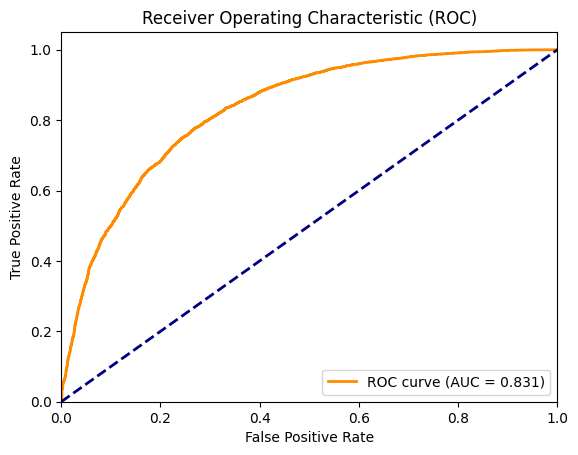

In [ ]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    probs = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # logits
            probabilities = torch.softmax(outputs, dim=1)[:,1]  # probability of class 1 (deepfake)
            probs.extend(probabilities.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(true_labels), np.array(probs)

# Assuming you have your model, test_loader, device ready:
true_labels, pred_probs = get_predictions_and_labels(model, test_loader, device)

fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


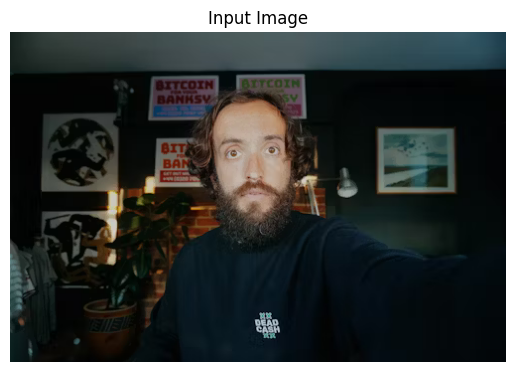

Prediction: Fake


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def predict_single_image(model, image_path, device):
    # Load and show the image
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Preprocess
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim

    # Prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, pred = torch.max(output, 1)

    classes = ['Fake', 'Real']  # Make sure order matches your dataset
    print(f'Prediction: {classes[pred.item()]}')

# Example usage:
predict_single_image(model, '/content/test1.png', device)


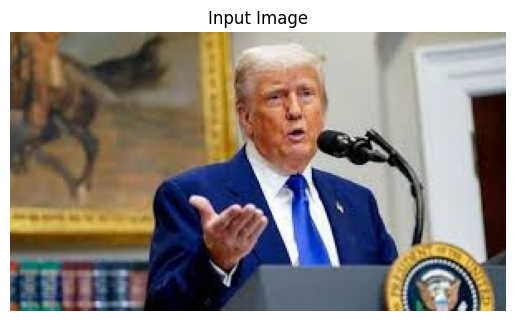

Prediction: Real


In [ ]:


def predict_single_image(model, image_path, device):
    # Load and show the image
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Preprocess
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim

    # Prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, pred = torch.max(output, 1)

    classes = ['Fake', 'Real']  # Make sure order matches your dataset
    print(f'Prediction: {classes[pred.item()]}')

# Example usage:
predict_single_image(model, '/content/test2.jpeg', device)
